# Оптимизация выплавки стали

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали, а также определит важность факторов, влияющих на температуру.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

НАШИ КРИТЕРИИ КАЧЕСТВА
MAE > 8.7 — 0 sp
7.6 < MAE ≤ 8.7 — 4 sp
6.8 < MAE ≤ 7.6 — 4.5 sp
6.3 < MAE ≤ 6.8 — 5 sp
6.0 < MAE ≤ 6.3 — 5.5 sp
MAE ≤ 6.0 — 6 sp

## Первичный анализ данных

In [1]:
#!pip install lightgbm

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#from pandas_profiling import ProfileReport
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.metrics import *
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import display
import seaborn as sns

pd.set_option('display.max_columns', None)

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Данные об электродах

In [4]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [9]:
#ProfileReport(data_arc)

В измерениях присутстуют данные по 3241 партии. Пропуски отсутствуют. Есть экстремальные значения реактивной мощности.
Активная и реактивная мощности сиально коррелируют между собой. Для признаков по каждой партии нам потребуется только суммарнмя полезная (активная) потребленная мощность: Активная мощность, помноженная на время приложения.

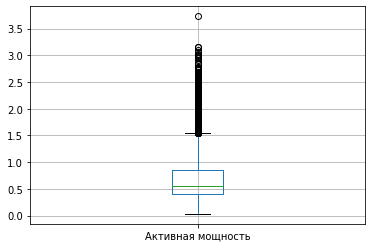

In [10]:
%matplotlib inline

data_arc.boxplot(column='Активная мощность')
plt.show()

### Данные о температуре

In [11]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [12]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [13]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [14]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [15]:
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


В ~20% замерах указаны пустые значения. Также, из каждой партии нам понадобится взять только первый и последний замеры. Первый, соотственно, уйдет в признаки, последний - в целевой признак. При этом, после последнего измерения не должно применяться нагрева и добавления легирующих материалов.

In [16]:
#Сгруппируем данные о первой и последней температуре по партиям
temp = data_temp.groupby('key').agg(['first', 'last'])
temp.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']
temp.isna().sum()

time_first    0
time_last     0
temp_first    0
temp_last     0
dtype: int64

In [17]:
temp.count()

time_first    3216
time_last     3216
temp_first    3216
temp_last     3216
dtype: int64

In [18]:
temp

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...
3237,2019-08-31 22:44:04,2019-08-31 23:05:43,1569.0,1569.0
3238,2019-08-31 23:30:31,2019-08-31 23:43:00,1584.0,1584.0
3239,2019-09-01 01:31:47,2019-09-01 02:24:15,1598.0,1598.0


In [19]:
#ProfileReport(temp)

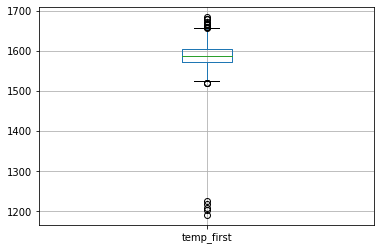

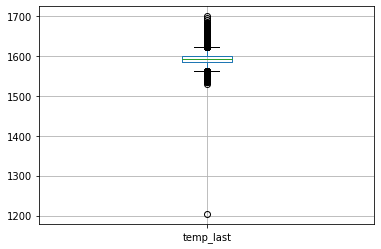

In [20]:
%matplotlib inline

temp.boxplot(column=('temp_first'))
plt.show()
temp.boxplot(column=('temp_last'))
plt.show()

### Данные о подаче сыпучих веществ

In [21]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [22]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [23]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [24]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [25]:
#ProfileReport(data_bulk)

In [26]:
#Проверим, нет ли полностью пустых строк
print(data_bulk.isna().all().sum())
print(data_bulk_time.isna().all().sum())


0
0


В распределении объемов по некоторым сыпучим веществам присутствуют выбросы с аномально высокими значениями. Нужно ли от них избавляться - стоит узнать у заказчика.

### Данные о продувке газом

In [27]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [28]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [29]:
#ProfileReport(data_gas)

Аналогично сыпучим добавкам, здесь тоже присутствуют аномально низкие и высокие объемы.

### Данные о подаче проволочных добавок

In [30]:
#ProfileReport(data_wire)

In [31]:
#Проверим, нет ли полностью пустых строк
print(data_wire.isna().all().sum())
print(data_wire_time.isna().all().sum())

0
0


In [32]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [34]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Выводы по первичному анализу и план работ
- Данные по температуре мы сгруппировали по партиям, избавившись от пропусков
- Количество партий отличается в разных таблицах. Это нужно учесть при их объединении в единую таблицу признаков, оставив только те партии, для которых есть полный набор данных.
- В данных присутствуют выбросы. 
- Названия колонок необходимо будет привести к латинице для унификации.
- Формат колонок с датами приведем к типу datetime.

**План дальнейших работ:**
1. Подготовка таблицы с признаками и целевым признаком:
    - Унификация формата колонок
    - Вычисление суммарного потребления активной мощности по каждой партии
    - Удаление партий, содержащих пропуски в измерениях температуры
    - Замена пустых значений в данных по веществам на нули
    - Удаление явных выбросов: значений < q1-3*iqr и >q3+3*iqr
    - Объединение таблиц
    - Удаление записей о партиях с некорректными финальными измерениями
2. Подготовка тренировочной и тестовой выборок с признаками и целевым признаком.
3. Обучение и настройка гиперпараметров нескольких моделей
4. Сравнение получившихся целевых метрик предсказания у различных моделей и выбор наилучшей.
5. Анализ важности факторов.

## Подготовка данных для машинного обучения

### Подготовка данных по электродам

In [35]:
#Unify columns names and change index
arc = data_arc.set_index('key')
arc.columns=['heating_start', 'heating_end', 'active_power', 'reactive_power']
arc = arc.drop(columns=['reactive_power'])

In [36]:
arc['heating_start'] = pd.to_datetime(arc.heating_start)
arc['heating_end'] = pd.to_datetime(arc.heating_end)

In [37]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [38]:
arc['period'] = (arc.heating_end - arc.heating_start)/np.timedelta64(1, 'h')

In [39]:
arc.head()

,heating_start,heating_end,active_power,period
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.063333
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.051389
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.047778
1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,0.101389
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.041111


In [40]:
arc['consumption'] = arc.active_power*arc.period

In [41]:
arc = arc.drop(columns=['period', 'active_power'])

In [42]:
arc.head(10)

,heating_start,heating_end,consumption
key,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.061817
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.041399
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.035564
1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.168241
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.028480
2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.016671
2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.121719
2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.017163
2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.048285


In [43]:
arc = pd.DataFrame(arc.groupby('key')['consumption'].sum())

In [44]:
arc.head()

,consumption
key,
1,0.335501
2,0.203838
3,0.123218
4,0.186295
5,0.277082


<AxesSubplot:>

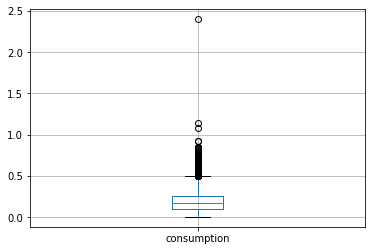

In [45]:
arc.boxplot()

Явные выбросы > q3+3*iqr удалим после объединения в общий датасет ниже

### Подготовка данных по температуре

In [46]:
#Removing batches with NaNs and grouping by batch number
temp = data_temp.groupby('key').filter(lambda g: (g['Температура'].isna() != True).all().all()).groupby('key').agg(['first', 'last'])

In [47]:
temp.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']
temp['time_first'] = pd.to_datetime(temp.time_first)
temp['time_last'] = pd.to_datetime(temp.time_last)

In [48]:
temp.head()

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


<AxesSubplot:>

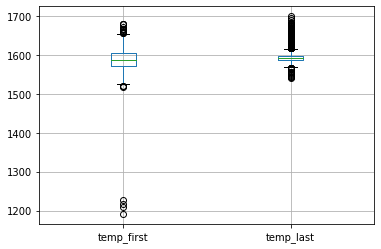

In [49]:
temp.boxplot()

Явные выбросы > q3+3*iqr удалим после объединения в общий датасет ниже

### Подготовка данных по подаче компонентов

In [50]:
#Prepare gas data
gas = data_gas.set_index('key')
gas.columns = ['gas_1']

In [51]:
#Prepare bulk additives data
bulk = data_bulk.set_index('key')
bulk.columns = ['bulk_'+str(k) for k in range(1,16)]

bulk_time = data_bulk_time.set_index('key')
bulk_time.columns = ['bulk_time_'+str(k) for k in range(1,16)]
bulk_time = pd.to_datetime(bulk_time.stack(), errors='ignore').unstack()
bulk_time = bulk_time.fillna(pd.to_datetime('1900-01-01'))

In [52]:
#Prepare wire additives data
wire = data_wire.set_index('key')
wire.columns = ['wire_'+str(k) for k in range(1,10)]

wire_time = data_wire_time.set_index('key')
wire_time.columns = ['wire_time_'+str(k) for k in range(1,10)]
wire_time = pd.to_datetime(wire_time.stack(), errors='ignore').unstack()
wire_time = wire_time.fillna(pd.to_datetime('1900-01-01'))

In [53]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   wire_time_1  3081 non-null   datetime64[ns]
 1   wire_time_2  3081 non-null   datetime64[ns]
 2   wire_time_3  3081 non-null   datetime64[ns]
 3   wire_time_4  3081 non-null   datetime64[ns]
 4   wire_time_5  3081 non-null   datetime64[ns]
 5   wire_time_6  3081 non-null   datetime64[ns]
 6   wire_time_7  3081 non-null   datetime64[ns]
 7   wire_time_8  3081 non-null   datetime64[ns]
 8   wire_time_9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


### Объединение данных

In [54]:
wire_time.head(10)

,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,
1,2019-05-03 11:11:41,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
2,2019-05-03 11:46:10,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
3,2019-05-03 12:13:47,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
4,2019-05-03 12:48:05,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
5,2019-05-03 13:18:15,2019-05-03 13:32:06,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
6,2019-05-03 13:59:02,2019-05-03 13:59:54,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
7,2019-05-03 14:28:46,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
8,2019-05-03 15:03:42,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
9,2019-05-03 15:42:43,2019-05-03 15:58:12,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01


In [55]:
data = arc.join([temp, gas, bulk, bulk_time, wire, wire_time], how='inner')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 54 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   consumption   2329 non-null   float64       
 1   time_first    2329 non-null   datetime64[ns]
 2   time_last     2329 non-null   datetime64[ns]
 3   temp_first    2329 non-null   float64       
 4   temp_last     2329 non-null   float64       
 5   gas_1         2329 non-null   float64       
 6   bulk_1        199 non-null    float64       
 7   bulk_2        13 non-null     float64       
 8   bulk_3        960 non-null    float64       
 9   bulk_4        812 non-null    float64       
 10  bulk_5        53 non-null     float64       
 11  bulk_6        438 non-null    float64       
 12  bulk_7        13 non-null     float64       
 13  bulk_8        1 non-null      float64       
 14  bulk_9        13 non-null     float64       
 15  bulk_10       143 non-null    float64 

In [57]:
data.head()

,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.335501,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,1900-01-01,1900-01-01,1900-01-01,2019-05-03 11:21:30,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-03 11:03:52,1900-01-01,2019-05-03 11:03:52,2019-05-03 11:03:52,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
2,0.203838,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,1900-01-01,1900-01-01,1900-01-01,2019-05-03 11:46:38,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-03 11:40:20,1900-01-01,2019-05-03 11:40:20,2019-05-03 11:40:20,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:46:10,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
3,0.123218,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,1900-01-01,1900-01-01,1900-01-01,2019-05-03 12:31:06,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-03 12:09:40,1900-01-01,2019-05-03 12:09:40,2019-05-03 12:09:40,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
4,0.186295,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,1900-01-01,1900-01-01,1900-01-01,2019-05-03 12:48:43,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-03 12:41:24,1900-01-01,2019-05-03 12:41:24,2019-05-03 12:41:24,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
5,0.277082,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,1900-01-01,1900-01-01,1900-01-01,2019-05-03 13:18:50,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-03 13:12:56,1900-01-01,2019-05-03 13:12:56,2019-05-03 13:12:56,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:18:15,2019-05-03 13:32:06,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01


#### Удаление выбросов

In [58]:
#Removing outliers
def remove_outliers(df, columns, verbose=True):
    data = df.copy()
    all_burst_index = []
    print("Deleting outliers...")
    for col in columns:
        col_hi_burst_index = []
        col_lo_burst_index = []
        iqr = df[col].quantile(0.75)-df[col].quantile(0.25)
        
        col_hi_burst_index.extend(data[data[col] > (data[col].quantile(0.75) + 3*iqr)].index)
        col_lo_burst_index.extend(data[data[col] < (data[col].quantile(0.25) - 3*iqr)].index)
        
        if (len(col_hi_burst_index)>0 & verbose):
            print("\n")
            print(f'{col.upper()}: deleted {len(col_hi_burst_index)} rows with too high values, showing first 5:')
            display(data.loc[col_hi_burst_index,:].head(5))
        if (len(col_lo_burst_index)>0 & verbose):
            print("\n")
            print(f'{col.upper()}: deleted {len(col_lo_burst_index)} rows with too low values, showing first 5:')
            display(data.loc[col_lo_burst_index,:].head(5))
        
        all_burst_index.extend(col_hi_burst_index)
        all_burst_index.extend(col_lo_burst_index)
    #Remove duplicate indexes from the list
    all_burst_index = list(set(all_burst_index))
    data = data.drop(all_burst_index)
    
    return data
num_columns = ['consumption', 'temp_first', 'temp_last', 'gas_1']+['bulk_'+str(k) for k in range(1,16)]+['wire_'+str(k) for k in range(1,10)]
data = remove_outliers(data, num_columns)

Deleting outliers...


CONSUMPTION: deleted 22 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
46,0.921643,2019-05-04 23:54:43,2019-05-05 03:14:53,1607.0,1612.0,6.118441,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,204.0,NaN,401.0,204.0,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-05 00:51:48,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-05 00:44:23,1900-01-01,2019-05-05 00:00:34,2019-05-05 00:44:23,100.245593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-05 00:50:41,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
291,0.727915,2019-05-14 06:19:13,2019-05-14 07:22:40,1591.0,1617.0,17.724259,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,70.0,NaN,459.0,NaN,256.0,154.0,1900-01-01,1900-01-01,1900-01-01,2019-05-14 07:04:50,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,2019-05-14 07:04:50,1900-01-01,2019-05-14 06:21:39,1900-01-01,2019-05-14 06:21:39,2019-05-14 06:21:39,176.117752,30.110081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-14 07:03:21,2019-05-14 07:16:57,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
335,0.743190,2019-05-15 22:24:10,2019-05-15 23:28:09,1564.0,1612.0,5.541493,NaN,NaN,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,NaN,410.0,NaN,208.0,205.0,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-15 22:37:41,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-15 22:26:05,1900-01-01,2019-05-15 22:26:05,2019-05-15 22:26:05,73.429200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-15 22:36:45,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
416,0.774917,2019-05-18 19:11:09,2019-05-18 20:09:23,1569.0,1612.0,20.511666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360.0,NaN,327.0,125.0,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-18 19:16:25,1900-01-01,2019-05-18 19:13:44,2019-05-18 19:16:25,112.132797,21.112000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-18 19:44:56,2019-05-18 19:45:29,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
437,0.840852,2019-05-19 12:54:51,2019-05-19 13:56:58,1600.0,1618.0,17.274926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,260.0,152.0,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-19 12:58:18,1900-01-01,2019-05-19 12:58:18,2019-05-19 12:58:18,119.199600,67.105999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-19 13:11:51,2019-05-19 13:13:31,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




TEMP_FIRST: deleted 4 rows with too low values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
867,0.186372,2019-06-04 14:21:00,2019-06-04 14:57:17,1191.0,1599.0,11.616807,NaN,NaN,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,117.0,104.0,1900-01-01,1900-01-01,2019-06-04 14:43:10,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-04 14:38:05,1900-01-01,2019-06-04 14:38:05,2019-06-04 14:38:05,158.511604,35.07608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-04 14:32:56,2019-06-04 14:43:58,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1214,0.123519,2019-06-16 05:32:00,2019-06-16 06:14:45,1208.0,1591.0,12.933558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,124.0,101.0,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-16 05:45:30,1900-01-01,2019-06-16 05:45:30,2019-06-16 05:45:30,53.118000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-16 05:50:12,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1619,0.029464,2019-06-30 11:03:54,2019-06-30 11:21:54,1218.0,1590.0,4.542025,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01,1900-01-01,2019-06-30 11:20:36,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,155.141998,45.17968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-30 11:09:09,2019-06-30 11:21:02,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
2052,0.112678,2019-07-21 14:51:40,2019-07-21 15:24:06,1227.0,1592.0,8.639928,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,100.0,103.0,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-21 15:11:42,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-21 14:54:43,1900-01-01,2019-07-21 14:54:43,2019-07-21 14:54:43,116.014076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-21 15:11:16,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




TEMP_LAST: deleted 4 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
113,0.269323,2019-05-07 08:19:04,2019-05-07 09:08:33,1645.0,1647.0,25.377930,NaN,228.0,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01,2019-05-07 08:36:19,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-05-07 08:36:19,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,7.556640,NaN,96.047951,24.148801,NaN,60.094322,NaN,NaN,NaN,2019-05-07 08:34:28,1900-01-01,2019-05-07 08:50:29,2019-05-07 08:48:23,1900-01-01,2019-05-07 08:37:20,1900-01-01,1900-01-01,1900-01-01
684,0.411233,2019-05-28 15:32:50,2019-05-28 15:59:23,1575.0,1642.0,8.210977,NaN,NaN,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,561.0,NaN,264.0,206.0,1900-01-01,1900-01-01 00:00:00,2019-05-28 15:40:40,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-28 15:30:45,1900-01-01,2019-05-28 15:30:45,2019-05-28 15:30:45,107.265594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-28 15:40:23,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01
1563,0.486076,2019-06-28 16:21:51,2019-06-28 17:01:11,1628.0,1653.0,10.906249,NaN,NaN,NaN,158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,479.0,NaN,199.0,NaN,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-06-28 16:43:53,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-28 16:23:42,1900-01-01,2019-06-28 16:23:42,1900-01-01 00:00:00,249.958786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-28 16:43:09,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01
1804,0.162460,2019-07-06 10:23:37,2019-07-06 11:00:28,1658.0,1633.0,1.870435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,98.0,104.0,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-06 10:52:19,1900-01-01,2019-07-06 10:52:19,2019-07-06 10:52:19,147.139206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-06 10:44:28,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01




TEMP_LAST: deleted 6 rows with too low values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
115,0.089220,2019-05-07 11:01:24,2019-05-07 12:39:22,1635.0,1547.0,22.201580,78.0,232.0,NaN,21.0,112.0,NaN,178.0,NaN,NaN,NaN,67.0,NaN,NaN,NaN,NaN,2019-05-07 11:24:41,2019-05-07 11:37:42,1900-01-01,2019-05-07 12:25:51,2019-05-07 11:37:42,1900-01-01,2019-05-07 11:37:42,1900-01-01,1900-01-01,1900-01-01,2019-05-07 11:37:42,1900-01-01,1900-01-01,1900-01-01,1900-01-01,NaN,NaN,NaN,NaN,NaN,64.212723,NaN,NaN,NaN,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,2019-05-07 11:38:44,1900-01-01 00:00:00,1900-01-01,1900-01-01
1948,0.188416,2019-07-17 11:04:43,2019-07-17 11:46:14,1530.0,1550.0,10.406837,NaN,NaN,NaN,NaN,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,2019-07-17 11:25:12,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,10.22112,NaN,NaN,25.132641,NaN,NaN,NaN,NaN,NaN,2019-07-17 11:21:50,1900-01-01,1900-01-01 00:00:00,2019-07-17 11:25:32,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01
2106,0.260813,2019-07-23 10:44:51,2019-07-23 12:53:19,1602.0,1545.0,19.455820,43.0,249.0,NaN,83.0,103.0,NaN,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-23 11:07:27,2019-07-23 11:10:20,1900-01-01,2019-07-23 11:10:20,2019-07-23 11:10:20,1900-01-01,2019-07-23 11:10:20,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,4.06224,NaN,95.375282,113.231044,NaN,68.434087,5.035472,NaN,NaN,2019-07-23 12:39:24,1900-01-01,2019-07-23 11:25:12,2019-07-23 11:12:30,1900-01-01,2019-07-23 11:12:06,2019-07-23 12:42:00,1900-01-01,1900-01-01
2107,0.108991,2019-07-23 11:22:00,2019-07-23 13:38:34,1641.0,1543.0,29.671167,30.0,282.0,NaN,113.0,146.0,NaN,392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-23 11:49:52,2019-07-23 11:52:43,1900-01-01,2019-07-23 11:52:43,2019-07-23 11:52:43,1900-01-01,2019-07-23 11:52:43,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,9.08544,NaN,93.165077,82.150638,NaN,99.219122,8.490040,NaN,NaN,2019-07-23 12:19:36,1900-01-01,2019-07-23 11:58:58,2019-07-23 11:52:57,1900-01-01,2019-07-23 11:53:52,2019-07-23 12:08:44,1900-01-01,1900-01-01
2108,0.754516,2019-07-23 14:09:40,2019-07-23 19:58:23,1639.0,1541.0,45.638999,63.0,242.0,NaN,98.0,94.0,NaN,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-23 14:35:55,2019-07-23 14:35:55,1900-01-01,2019-07-23 14:37:23,2019-07-23 14:35:55,1900-01-01,2019-07-23 14:35:55,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,11.05104,NaN,93.213127,92.570401,NaN,63.045845,1.053936,NaN,NaN,2019-07-23 19:50:47,1900-01-01,2019-07-23 14:43:41,2019-07-23 14:40:29,1900-01-01,2019-07-23 14:38:11,2019-07-23 19:46:16,1900-01-01,1900-01-01




GAS_1: deleted 14 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
117,0.123899,2019-05-07 15:26:23,2019-05-07 16:19:27,1625.0,1604.0,50.581035,52.0,325.0,NaN,68.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-07 15:37:52,2019-05-07 15:45:34,1900-01-01 00:00:00,2019-05-07 16:13:03,2019-05-07 15:45:34,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,NaN,NaN,93.068977,NaN,NaN,26.975523,NaN,NaN,NaN,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-05-07 15:50:31,1900-01-01 00:00:00,1900-01-01,2019-05-07 15:48:13,1900-01-01,1900-01-01 00:00:00,1900-01-01
118,0.562017,2019-05-07 16:13:55,2019-05-07 18:53:53,1652.0,1600.0,38.982740,69.0,257.0,NaN,68.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-07 16:15:34,2019-05-07 16:27:56,1900-01-01 00:00:00,2019-05-07 16:27:56,2019-05-07 16:27:56,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,NaN,NaN,94.990898,33.182243,NaN,60.025684,NaN,NaN,NaN,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-05-07 16:34:12,2019-05-07 16:09:18,1900-01-01,2019-05-07 16:29:11,1900-01-01,1900-01-01 00:00:00,1900-01-01
280,0.523541,2019-05-13 23:20:22,2019-05-14 00:08:09,1532.0,1600.0,60.935689,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,108.0,NaN,263.0,NaN,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-05-13 23:51:46,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,2019-05-14 00:04:56,1900-01-01,1900-01-01,2019-05-13 23:23:23,1900-01-01,2019-05-13 23:23:23,1900-01-01 00:00:00,160.174557,76.236166,NaN,NaN,NaN,NaN,NaN,46.002319,NaN,2019-05-13 23:40:41,2019-05-13 23:52:04,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-05-14 00:03:32,1900-01-01
322,0.678726,2019-05-15 09:10:07,2019-05-15 11:02:12,1619.0,1616.0,77.995040,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,2019-05-15 09:27:40,1900-01-01 00:00:00,2019-05-15 09:35:53,2019-05-15 09:58:38,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-05-15 09:35:53,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,2019-05-15 09:22:19,1900-01-01,2019-05-15 09:22:19,1900-01-01 00:00:00,NaN,188.228550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01 00:00:00,2019-05-15 09:37:48,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01
528,0.324599,2019-05-22 21:48:12,2019-05-22 22:28:31,1609.0,1615.0,39.728826,NaN,NaN,NaN,NaN,NaN,69.0,NaN,NaN,NaN,NaN,NaN,412.0,NaN,324.0,155.0,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2019-05-22 21:44:34,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,2019-05-22 21:32:58,1900-01-01,2019-05-22 21:32:58,2019-05-22 21:32:58,131.461196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-22 21:43:03,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01




BULK_1: deleted 1 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
322,0.678726,2019-05-15 09:10:07,2019-05-15 11:02:12,1619.0,1616.0,77.99504,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,2019-05-15 09:27:40,1900-01-01,2019-05-15 09:35:53,2019-05-15 09:58:38,1900-01-01,1900-01-01,2019-05-15 09:35:53,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-15 09:22:19,1900-01-01,2019-05-15 09:22:19,1900-01-01,NaN,188.22855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01,2019-05-15 09:37:48,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




BULK_2: deleted 1 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
117,0.123899,2019-05-07 15:26:23,2019-05-07 16:19:27,1625.0,1604.0,50.581035,52.0,325.0,NaN,68.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-07 15:37:52,2019-05-07 15:45:34,1900-01-01,2019-05-07 16:13:03,2019-05-07 15:45:34,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,NaN,NaN,93.068977,NaN,NaN,26.975523,NaN,NaN,NaN,1900-01-01,1900-01-01,2019-05-07 15:50:31,1900-01-01,1900-01-01,2019-05-07 15:48:13,1900-01-01,1900-01-01,1900-01-01




BULK_3: deleted 2 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1028,0.246820,2019-06-10 01:48:14,2019-06-10 02:22:04,1575.0,1585.0,10.195418,NaN,NaN,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0,205.0,NaN,102.0,103.0,1900-01-01,1900-01-01,2019-06-10 01:59:20,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-10 01:59:20,2019-06-10 01:53:24,1900-01-01,2019-06-10 01:53:24,2019-06-10 01:53:24,53.071201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-10 01:57:16,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1925,0.422293,2019-07-16 06:00:54,2019-07-16 06:46:40,1564.0,1590.0,17.289445,NaN,NaN,445.0,NaN,NaN,204.0,NaN,NaN,NaN,NaN,NaN,205.0,NaN,348.0,104.0,1900-01-01,1900-01-01,2019-07-16 06:33:50,1900-01-01,1900-01-01,2019-07-16 06:20:47,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-16 06:15:03,1900-01-01,2019-07-16 06:07:17,2019-07-16 06:15:03,75.129601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-16 06:19:39,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




BULK_5: deleted 1 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1808,0.127318,2019-07-06 14:54:06,2019-07-06 15:10:25,1608.0,1597.0,5.004994,NaN,NaN,226.0,30.0,603.0,NaN,NaN,NaN,NaN,NaN,NaN,210.0,NaN,99.0,104.0,1900-01-01,1900-01-01,2019-07-06 15:06:36,2019-07-06 15:06:36,2019-07-06 15:06:36,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-06 15:01:08,1900-01-01,2019-07-06 15:01:08,2019-07-06 15:01:08,62.009998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-06 15:06:08,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




BULK_6: deleted 1 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1269,0.254513,2019-06-18 05:21:21,2019-06-18 07:30:24,1627.0,1584.0,20.882042,NaN,NaN,163.0,NaN,NaN,503.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304.0,203.0,1900-01-01,1900-01-01,2019-06-18 06:54:29,1900-01-01,1900-01-01,2019-06-18 06:54:29,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-18 05:25:21,2019-06-18 05:25:21,142.3656,282.780152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18 05:28:44,2019-06-18 06:56:35,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




BULK_9: deleted 3 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1786,0.137867,2019-07-05 17:22:23,2019-07-05 17:49:04,1574.0,1579.0,12.648400,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01,1900-01-01,2019-07-05 17:26:55,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,2019-07-05 17:46:11,2019-07-05 17:44:46,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,175.219193,48.286160,NaN,NaN,NaN,NaN,NaN,68.494405,NaN,2019-07-05 17:24:48,2019-07-05 17:27:15,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-05 17:34:22,1900-01-01
1975,0.202333,2019-07-18 17:00:19,2019-07-18 17:40:28,1597.0,1594.0,20.558726,NaN,NaN,NaN,176.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,126.0,NaN,178.0,87.0,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 17:20:39,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 17:35:46,1900-01-01,1900-01-01,2019-07-18 17:03:19,1900-01-01,2019-07-18 17:03:19,2019-07-18 17:03:19,99.503036,100.764565,NaN,NaN,NaN,NaN,NaN,102.762401,NaN,2019-07-18 17:08:01,2019-07-18 16:57:02,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-18 17:36:23,1900-01-01
1976,0.241555,2019-07-18 18:20:34,2019-07-18 19:08:24,1592.0,1595.0,14.221584,NaN,NaN,NaN,108.0,NaN,NaN,NaN,NaN,108.0,NaN,NaN,NaN,NaN,129.0,NaN,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 18:44:10,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 18:58:01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-07-18 18:24:05,1900-01-01 00:00:00,115.140480,30.129841,NaN,NaN,NaN,NaN,NaN,95.244248,NaN,2019-07-18 18:33:26,2019-07-18 18:44:38,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-18 18:58:07,1900-01-01




BULK_12: deleted 3 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
322,0.678726,2019-05-15 09:10:07,2019-05-15 11:02:12,1619.0,1616.0,77.99504,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,2019-05-15 09:27:40,1900-01-01,2019-05-15 09:35:53,2019-05-15 09:58:38,1900-01-01,1900-01-01,2019-05-15 09:35:53,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-15 09:22:19,1900-01-01,2019-05-15 09:22:19,1900-01-01 00:00:00,NaN,188.22855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01 00:00:00,2019-05-15 09:37:48,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1816,0.381319,2019-07-06 22:14:17,2019-07-06 23:08:06,1590.0,1591.0,23.48817,62.0,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833.0,NaN,249.0,NaN,2019-07-06 22:24:47,1900-01-01,1900-01-01 00:00:00,2019-07-06 22:36:05,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-06 22:24:47,1900-01-01,2019-07-06 22:17:57,1900-01-01 00:00:00,236.667587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-06 22:35:16,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1999,0.125685,2019-07-19 18:01:01,2019-07-19 18:37:14,1650.0,1613.0,7.81519,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.0,NaN,366.0,290.0,2019-07-19 18:07:06,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-19 18:03:28,1900-01-01,2019-07-19 18:03:28,2019-07-19 18:03:28,100.070877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-19 18:20:12,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




BULK_13: deleted 3 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
204,0.115769,2019-05-10 21:12:38,2019-05-10 21:44:42,1603.0,1591.0,12.104109,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.0,278.0,NaN,158.0,1900-01-01,1900-01-01,1900-01-01,2019-05-10 21:25:33,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-10 21:16:38,2019-05-10 21:16:38,1900-01-01 00:00:00,2019-05-10 21:16:38,134.184952,20.354880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-10 21:24:59,2019-05-10 21:25:46,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
948,0.255591,2019-06-07 12:30:35,2019-06-07 13:09:24,1562.0,1583.0,10.227308,NaN,NaN,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,259.0,204.0,NaN,NaN,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-06-07 12:42:07,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-07 12:36:20,2019-06-07 12:36:20,1900-01-01 00:00:00,1900-01-01 00:00:00,80.074799,21.202478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-07 12:41:15,2019-06-07 12:42:23,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1689,2.395679,2019-07-02 15:28:21,2019-07-02 22:00:38,1583.0,1606.0,33.597044,NaN,NaN,NaN,NaN,NaN,247.0,NaN,NaN,NaN,NaN,NaN,733.0,305.0,248.0,224.0,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-07-02 15:45:57,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-02 15:33:13,2019-07-02 18:49:35,2019-07-02 15:33:13,2019-07-02 15:33:13,187.153206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-02 15:45:22,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




BULK_14: deleted 1 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
322,0.678726,2019-05-15 09:10:07,2019-05-15 11:02:12,1619.0,1616.0,77.99504,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,2019-05-15 09:27:40,1900-01-01,2019-05-15 09:35:53,2019-05-15 09:58:38,1900-01-01,1900-01-01,2019-05-15 09:35:53,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-15 09:22:19,1900-01-01,2019-05-15 09:22:19,1900-01-01,NaN,188.22855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01,2019-05-15 09:37:48,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




WIRE_1: deleted 1 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1821,0.085457,2019-07-07 03:16:15,2019-07-07 04:14:16,1644.0,1615.0,17.995657,NaN,NaN,343.0,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,99.0,204.0,1900-01-01,1900-01-01,2019-07-07 03:40:08,1900-01-01,2019-07-07 03:40:08,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-07 03:34:03,1900-01-01,2019-07-07 03:34:03,2019-07-07 03:34:03,330.314424,69.337838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-07 03:21:46,2019-07-07 03:40:20,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




WIRE_2: deleted 3 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
953,0.324542,2019-06-07 15:13:47,2019-06-07 15:36:02,1537.0,1578.0,10.672874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,358.0,NaN,256.0,203.0,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-07 15:02:53,1900-01-01,2019-06-07 15:02:53,2019-06-07 15:02:53,110.120399,231.568481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-07 15:07:13,2019-06-07 15:09:35,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1269,0.254513,2019-06-18 05:21:21,2019-06-18 07:30:24,1627.0,1584.0,20.882042,NaN,NaN,163.0,NaN,NaN,503.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304.0,203.0,1900-01-01,1900-01-01,2019-06-18 06:54:29,1900-01-01,1900-01-01,2019-06-18 06:54:29,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-06-18 05:25:21,2019-06-18 05:25:21,142.365600,282.780152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18 05:28:44,2019-06-18 06:56:35,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01
1377,0.270109,2019-06-22 03:32:57,2019-06-22 04:02:58,1571.0,1604.0,7.982939,NaN,NaN,159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301.0,NaN,204.0,198.0,1900-01-01,1900-01-01,2019-06-22 03:47:24,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-06-22 03:37:27,1900-01-01,2019-06-22 03:37:27,2019-06-22 03:37:27,169.135192,220.348953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-22 03:35:23,2019-06-22 03:49:57,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01




WIRE_8: deleted 3 rows with too high values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1786,0.137867,2019-07-05 17:22:23,2019-07-05 17:49:04,1574.0,1579.0,12.648400,NaN,NaN,123.0,NaN,NaN,NaN,NaN,49.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,1900-01-01,1900-01-01,2019-07-05 17:26:55,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,2019-07-05 17:46:11,2019-07-05 17:44:46,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,1900-01-01 00:00:00,1900-01-01 00:00:00,175.219193,48.286160,NaN,NaN,NaN,NaN,NaN,68.494405,NaN,2019-07-05 17:24:48,2019-07-05 17:27:15,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-05 17:34:22,1900-01-01
1975,0.202333,2019-07-18 17:00:19,2019-07-18 17:40:28,1597.0,1594.0,20.558726,NaN,NaN,NaN,176.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,126.0,NaN,178.0,87.0,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 17:20:39,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 17:35:46,1900-01-01,1900-01-01,2019-07-18 17:03:19,1900-01-01,2019-07-18 17:03:19,2019-07-18 17:03:19,99.503036,100.764565,NaN,NaN,NaN,NaN,NaN,102.762401,NaN,2019-07-18 17:08:01,2019-07-18 16:57:02,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-18 17:36:23,1900-01-01
1976,0.241555,2019-07-18 18:20:34,2019-07-18 19:08:24,1592.0,1595.0,14.221584,NaN,NaN,NaN,108.0,NaN,NaN,NaN,NaN,108.0,NaN,NaN,NaN,NaN,129.0,NaN,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 18:44:10,1900-01-01,1900-01-01,1900-01-01,1900-01-01 00:00:00,2019-07-18 18:58:01,1900-01-01,1900-01-01,1900-01-01 00:00:00,1900-01-01,2019-07-18 18:24:05,1900-01-01 00:00:00,115.140480,30.129841,NaN,NaN,NaN,NaN,NaN,95.244248,NaN,2019-07-18 18:33:26,2019-07-18 18:44:38,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-07-18 18:58:07,1900-01-01




WIRE_8: deleted 2 rows with too low values, showing first 5:


,consumption,time_first,time_last,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_time_1,bulk_time_2,bulk_time_3,bulk_time_4,bulk_time_5,bulk_time_6,bulk_time_7,bulk_time_8,bulk_time_9,bulk_time_10,bulk_time_11,bulk_time_12,bulk_time_13,bulk_time_14,bulk_time_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_time_1,wire_time_2,wire_time_3,wire_time_4,wire_time_5,wire_time_6,wire_time_7,wire_time_8,wire_time_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
288,0.139207,2019-05-14 04:19:45,2019-05-14 04:41:53,1585.0,1584.0,22.368817,NaN,NaN,83.0,75.0,NaN,NaN,NaN,NaN,66.0,NaN,NaN,103.0,NaN,252.0,NaN,1900-01-01,1900-01-01,2019-05-14 04:36:36,2019-05-14 04:36:36,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-14 04:38:14,1900-01-01,1900-01-01,2019-05-14 04:21:54,1900-01-01,2019-05-14 04:21:54,1900-01-01,70.193764,NaN,NaN,NaN,NaN,NaN,NaN,45.076721,NaN,2019-05-14 04:26:38,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-14 04:37:08,1900-01-01
289,0.116270,2019-05-14 04:56:38,2019-05-14 05:19:16,1584.0,1589.0,14.172557,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,107.0,NaN,252.0,NaN,1900-01-01,1900-01-01,2019-05-14 05:13:38,1900-01-01 00:00:00,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-14 05:15:06,1900-01-01,1900-01-01,2019-05-14 04:59:23,1900-01-01,2019-05-14 04:59:23,1900-01-01,86.311676,20.180161,NaN,NaN,NaN,NaN,NaN,45.076721,NaN,2019-05-14 05:04:06,2019-05-14 05:13:57,1900-01-01,1900-01-01,1900-01-01,1900-01-01,1900-01-01,2019-05-14 05:14:25,1900-01-01


#### Удаление некорректных измерений

In [59]:
#Fill null values with zeroes
data = data.fillna(0)

In [60]:
#Remove batches with any additives added after last temperature measurement was made 
data = data.query('''time_last >= bulk_time_1 and time_last >= bulk_time_2 and time_last >= bulk_time_3  and time_last >= bulk_time_4 \
and time_last >= bulk_time_5 and time_last >= bulk_time_6 and time_last >= bulk_time_7 and time_last >= bulk_time_8 \
and time_last >= bulk_time_9 and time_last >= bulk_time_10 and time_last >= bulk_time_11 and time_last >= bulk_time_12 \
and time_last >= bulk_time_13 and time_last >= bulk_time_14 and time_last >= bulk_time_15 \
and time_last >= wire_time_1 and time_last >= wire_time_2 and time_last >= wire_time_3 and time_last >= wire_time_4 \
and time_last >= wire_time_5 and time_last >= wire_time_6 and time_last >= wire_time_7 and time_last >= wire_time_8 ''')

#Remove unnecessary features
drop_columns = ['bulk_time_'+str(k) for k in range(1,16)]+['wire_time_'+str(k) for k in range(1,10)]+['time_first', 'time_last']
data = data.drop(drop_columns, axis=1)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2257 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  2257 non-null   float64
 1   temp_first   2257 non-null   float64
 2   temp_last    2257 non-null   float64
 3   gas_1        2257 non-null   float64
 4   bulk_1       2257 non-null   float64
 5   bulk_2       2257 non-null   float64
 6   bulk_3       2257 non-null   float64
 7   bulk_4       2257 non-null   float64
 8   bulk_5       2257 non-null   float64
 9   bulk_6       2257 non-null   float64
 10  bulk_7       2257 non-null   float64
 11  bulk_8       2257 non-null   float64
 12  bulk_9       2257 non-null   float64
 13  bulk_10      2257 non-null   float64
 14  bulk_11      2257 non-null   float64
 15  bulk_12      2257 non-null   float64
 16  bulk_13      2257 non-null   float64
 17  bulk_14      2257 non-null   float64
 18  bulk_15      2257 non-null   float64
 19  wire_1

#### Анализ признаков на мультиколлинеарность

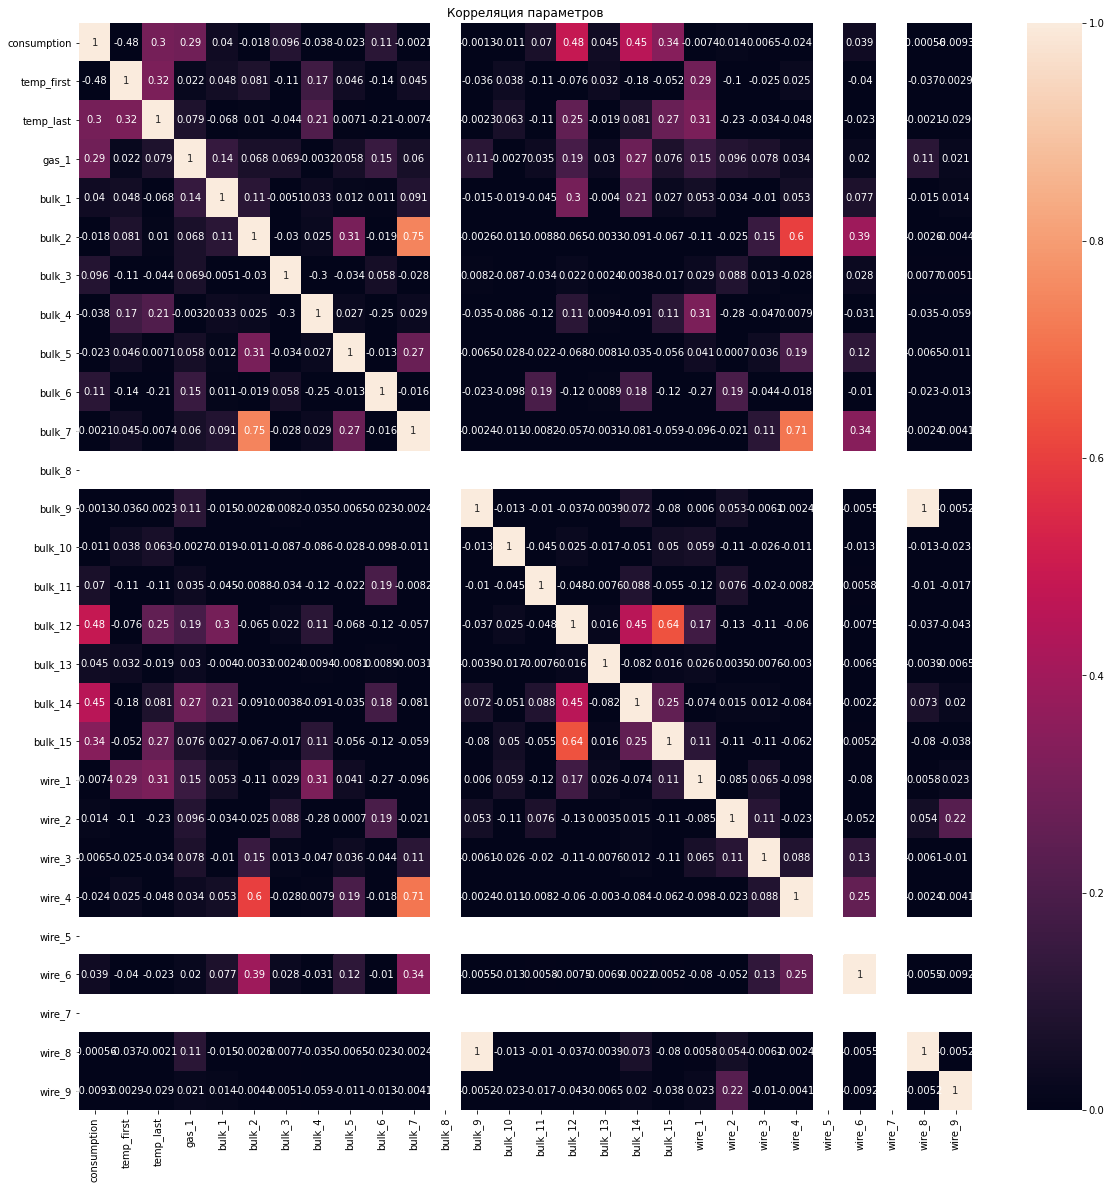

In [62]:
_, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, ax=ax, vmin=0, vmax=1)
ax.set_title('Корреляция параметров')
plt.show()

#### Скалирование и разделение на тренировочную и тестовую выборки

In [63]:
prep_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

In [64]:
#Split train and test
features = data.drop('temp_last', axis=1)
target = data['temp_last']
features_train_raw, features_test_raw, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123)

In [65]:
data

,consumption,temp_first,temp_last,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.335501,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.203838,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.123218,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.186295,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.277082,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.173935,1570.0,1591.0,7.125735,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.202186,1554.0,1591.0,9.412616,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.118760,1571.0,1589.0,6.271699,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
features_train = prep_pipe.fit_transform(features_train_raw)
features_train.shape

(1692, 27)

In [67]:
features_test = prep_pipe.transform(features_test_raw)
features_test.shape

(565, 27)

## Обучение моделей

### Линейная регрессия

In [68]:
#Обучение и проверка модели линейной регрессии
lr = LinearRegression().fit(features_train, target_train)

scores_lr = cross_val_score(lr, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print("Mean MAE using Linear Regression model:", scores_lr.mean())
print(scores_lr)
predictions = lr.predict(features_test)
print('MAE on test data:', mean_absolute_error(target_test, predictions))

Mean MAE using Linear Regression model: -5.941672322568346
[-6.36571337 -5.49625122 -6.02829033 -5.95372971 -5.86437698]
MAE on test data: 6.137930112275326


### Случайный лес

In [69]:
%%time

#Обучение и проверка модели случайного леса

params = {'n_estimators': range(10, 31, 5), 
         'max_depth': range(3, 15, 1)}
grid = GridSearchCV(RandomForestRegressor(random_state=123), param_grid=params, scoring='neg_mean_absolute_error', cv=5, refit=True)
grid.fit(features_train, target_train)
best_params = grid.best_params_
print(best_params)

rfr = grid.best_estimator_
print("Mean MAE using Random Forest Regressor:", grid.best_score_)

{'max_depth': 9, 'n_estimators': 25}
Mean MAE using Random Forest Regressor: -5.823449504046705
CPU times: user 45.9 s, sys: 170 ms, total: 46.1 s
Wall time: 48.8 s


In [70]:
predictions = rfr.predict(features_test)
print('MAE on test data:', mean_absolute_error(target_test, predictions))

MAE on test data: 5.898873881594081


In [71]:
#Get relative feature importance
importance_rfr = pd.DataFrame({'ratio': rfr.feature_importances_, 'features': features.columns })
importance_rfr

,ratio,features
0,0.270052,consumption
1,0.250044,temp_first
2,0.046139,gas_1
3,0.010148,bulk_1
4,0.004392,bulk_2
5,0.018552,bulk_3
6,0.021817,bulk_4
7,0.002068,bulk_5
8,0.073019,bulk_6
9,0.002991,bulk_7


### Catboost

In [72]:
%%time


catboost = CatBoostRegressor(iterations=3000, learning_rate=0.01)
catboost.fit(features_train, target_train, verbose=100)

0:	learn: 10.7288917	total: 52ms	remaining: 2m 35s
100:	learn: 8.6790744	total: 425ms	remaining: 12.2s
200:	learn: 7.8270363	total: 791ms	remaining: 11s
300:	learn: 7.4081661	total: 1.16s	remaining: 10.4s
400:	learn: 7.1561339	total: 1.53s	remaining: 9.89s
500:	learn: 6.9820685	total: 1.89s	remaining: 9.42s
600:	learn: 6.8315501	total: 2.25s	remaining: 8.99s
700:	learn: 6.6983676	total: 2.6s	remaining: 8.54s
800:	learn: 6.5798759	total: 2.96s	remaining: 8.13s
900:	learn: 6.4617141	total: 3.45s	remaining: 8.04s
1000:	learn: 6.3673553	total: 3.96s	remaining: 7.9s
1100:	learn: 6.2726628	total: 4.43s	remaining: 7.63s
1200:	learn: 6.1646795	total: 4.78s	remaining: 7.16s
1300:	learn: 6.0387062	total: 5.15s	remaining: 6.73s
1400:	learn: 5.9351186	total: 5.51s	remaining: 6.29s
1500:	learn: 5.8362076	total: 5.87s	remaining: 5.86s
1600:	learn: 5.7476432	total: 6.22s	remaining: 5.44s
1700:	learn: 5.6562805	total: 6.58s	remaining: 5.02s
1800:	learn: 5.5691652	total: 6.94s	remaining: 4.62s
1900:	le

In [73]:
predictions = catboost.predict(features_test)
print('Catboost MAE on test data:', mean_absolute_error(target_test, predictions))

Catboost MAE on test data: 5.768617250568807


In [74]:
catboost.get_feature_importance()

array([2.85607928e+01, 2.46652695e+01, 5.21433550e+00, 1.82269715e+00,
       1.10952384e-01, 2.29953248e+00, 2.80179318e+00, 2.96760499e-02,
       6.10673249e+00, 9.37529522e-02, 0.00000000e+00, 1.34996709e-02,
       2.85445603e-01, 6.45484569e-01, 4.01417008e+00, 2.19685763e-01,
       5.00931052e+00, 3.88826035e+00, 9.17542747e+00, 4.70668250e+00,
       9.25522772e-02, 9.19584530e-02, 0.00000000e+00, 1.03015298e-01,
       0.00000000e+00, 3.91517916e-02, 9.82115009e-03])

In [75]:
#Get relative feature importance
importance_catboost = pd.DataFrame({'ratio': catboost.get_feature_importance(), 'features': features.columns })

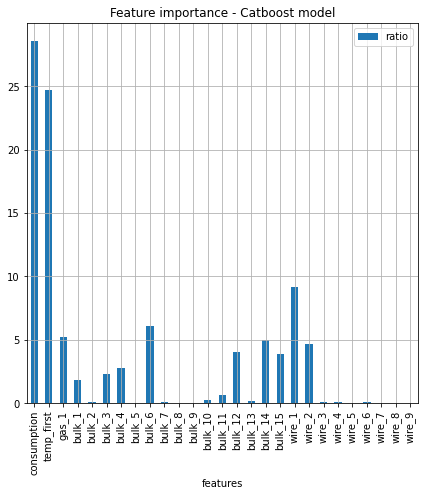

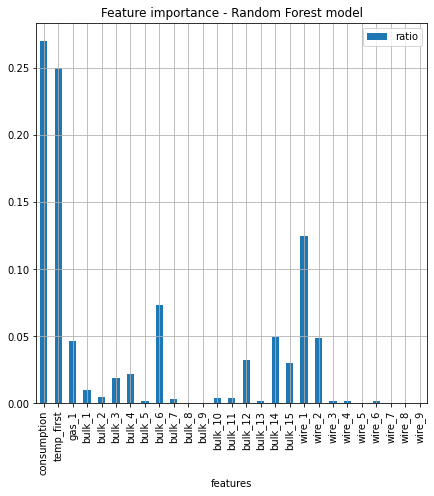

In [76]:
importance_catboost.plot(kind='bar', x='features',figsize=(7,7), title = 'Feature importance - Catboost model', grid='true')
plt.show()

importance_rfr.plot(kind='bar', x='features',figsize=(7,7), title = 'Feature importance - Random Forest model', grid='true')
plt.show()

In [77]:
#Build full pipeline
full_pipe = Pipeline([
    ("preparation", prep_pipe),
    ("catboost", CatBoostRegressor(iterations=3000, learning_rate=0.01, verbose=False))
])

full_pipe.fit(features_train_raw, target_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('std_scaler', StandardScaler())])),
                ('catboost',
                 <catboost.core.CatBoostRegressor object at 0x7f7fe2db8100>)])

In [78]:
predictions = full_pipe.predict(features_test_raw)

In [79]:
print("MAE:", mean_absolute_error(target_test, predictions))

MAE: 5.768617250568807


## Вывод

Выполнены все пункты намеченного плана.
Ключевым, и самым трудоемким, был этап предобработки данных для обучения, включа группировки и вычисления, удаление выбросов, нестыковок ни т.д. На этом этапе возникали мелкие технические сложности в коде. Не удалось решить задачу упаковки всех шагов предобработки в единый пайплайн из-за сложностей такой упаковки и недостатка знаний. Здесь требуется дальнейшее исследование возможностей кодирования пайплайнов.

Было проведено обучение и сравнение целевой метрики на трех моделях: Линейная регрессия, Случайный лес и Catboost. Результаты оказались близки, чуть меньшее значение MAE на тестовой выборке получено на Catboost: 5.77.